In [1]:
# to use cd, etc
import sys
import os

import numpy as np
# for math work
from numpy import linalg, matlib
# save, import and load data
from numpy import asarray, save, load

# needed for some matrix manipulations
import cvxpy as cp
# import math 

import scipy
# for curve fitting
from scipy import optimize
from scipy.io import loadmat  # this is the SciPy module that loads mat-files

from sklearn.metrics import r2_score, mean_squared_error

# import mat73
import pandas as pd

import matplotlib.pyplot as plt
# for plots
import seaborn
# set up seaborn for the plots
seaborn.set()

# suppress deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# # # to save data plots
# from matplotlib.backends.backend_pdf import PdfPages

# from datetime import datetime
import pickle

In [2]:
sessStart = '072312'
sessEnd = '080412'
savepath = '/Users/mmadduri/Documents/PhD/ResearchMaterials/Code/BMI_Model/data/' + 'jeev' + sessStart + '_' + sessEnd + '/'

In [3]:
with open(savepath + "cursorData.pkl", 'rb') as infile:
     kinList = pickle.load(infile)
kinData = np.asarray(kinList)[0]

In [4]:
with open(savepath + "decoder_2_neuralData.pkl", 'rb') as infile:
     decNum, usedUnits, succIdx, nData_succ = pickle.load(infile)

Shapes

* nB = number of time bins
* nN = number of neurons
* nT = number of trials

In [5]:
nB = nData_succ.shape[0]
nN = nData_succ.shape[1]
nT = nData_succ.shape[2]

In [6]:
usedUnits

array([ 50,  85, 105, 140, 215, 225, 270, 300, 395, 440, 520, 545, 590,
       595, 610, 635])

In [7]:
decNum

2

Index of successful trials in decoder only

In [8]:
succIdx

array([  41,   42,   43, ..., 2093, 2094, 2095])

Getting cursor data from only successful trials 

In [9]:
kinSucc = kinData[succIdx]

(array([ 12.,  35.,  67., 109., 188., 201., 386., 129., 152., 115.,  84.,
         72., 115.,  43.,  38.,  24.,  33.,  25.,  41.,  23.,  11.,  10.,
         13.,  12.,  22.,  10.,   4.,   7.,   5.,   4.,  14.,   0.,   6.,
          2.,   3.,   3.,   4.,   1.,   2.,   1.,   1.,   0.,   0.,   1.,
          2.,   0.,   2.,   2.,   4.,   1.,   0.,   0.,   0.,   0.,   1.,
          1.,   2.,   1.,   2.,   1.]),
 array([ 6.        ,  7.16666667,  8.33333333,  9.5       , 10.66666667,
        11.83333333, 13.        , 14.16666667, 15.33333333, 16.5       ,
        17.66666667, 18.83333333, 20.        , 21.16666667, 22.33333333,
        23.5       , 24.66666667, 25.83333333, 27.        , 28.16666667,
        29.33333333, 30.5       , 31.66666667, 32.83333333, 34.        ,
        35.16666667, 36.33333333, 37.5       , 38.66666667, 39.83333333,
        41.        , 42.16666667, 43.33333333, 44.5       , 45.66666667,
        46.83333333, 48.        , 49.16666667, 50.33333333, 51.5       ,
      

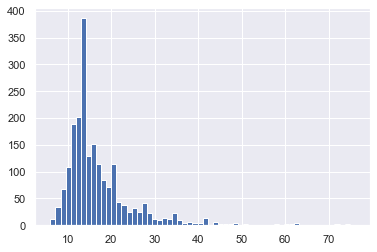

In [10]:
plt.hist([len(k) for k in kinSucc], 60)

In [11]:
len(kinSucc[0])

13

To check how many trials of a particular trial length

In [74]:
trLen = 5
kinLen = np.zeros(len(kinSucc))
overcount = 0
for iK in range(len(kinSucc)):
    kinLen[iK] = len(kinSucc[iK])    
    if (len(kinSucc[iK]) >= trLen):
        overcount = overcount + 1
print(overcount)

2047


08/25/2021

* how much feedforward is there? trying to estimate the ff and fb component
* how much structure is there in the ff component? how much of getting to the target is caused by a ff plan?
* 

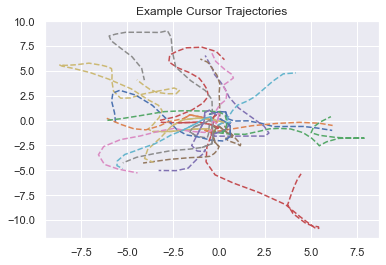

In [75]:
plt.title("Example Cursor Trajectories")
for iK in range(20):
    plt.plot(kinSucc[iK][:trLen, 0], kinSucc[iK][:trLen, 1]);
# plt.show()

for iK in range(20):
    plt.plot(kinSucc[iK][:, 0], kinSucc[iK][:, 1], '--');
plt.show()


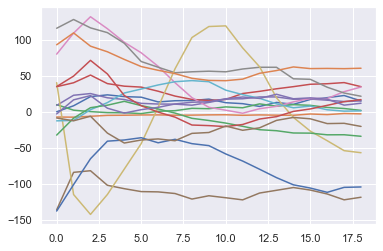

In [78]:
nData_succ.shape
nData = nData_succ/.1
plt.plot(np.mean(nData, 2));

Function to standardize arrays to zero-mean

In [79]:
#rescale to mean 0
def standardizeArray(array_in):
    return (array_in - np.mean(array_in))/ (np.max(array_in) - np.min(array_in))

In [80]:
nData_succ.shape

(19, 16, 2047)

Code to arrange the kinematic data and neural data into giant matrices

* k_flat.shape = (4 (number of states) x time bins) x number of trials
* nd_flat.shape = (initial state (4) + n_neurons x time bins) x number of trials

In [123]:
k_flat = []
k_ones = []
nd_flat = []
tr = []
for iK in range(len(kinSucc)):
    if (len(kinSucc[iK]) >= trLen):
        tr.append(iK)
        # make the cursor matrix
        k_iter = kinSucc[iK][0:trLen, :]
        ones = np.ones( (len(k_iter),1))
        k_iter_ones = np.hstack((k_iter, ones))
        k_ones.append(k_iter_ones)
        k_flat.append(k_iter_ones.flatten())
#         k_flat.append(k_iter.flatten())
        
        # make the neural activity matrix
        k0 = kinSucc[iK][0, :]
        nd_tr = (nData[0:trLen, :, iK].flatten())
#         np.concatenate((k0, nd_tr))
        nd_flat.append(np.concatenate((k0, nd_tr)))
        
k_flat = np.array(k_flat, dtype=float).T
nd_flat = np.array(nd_flat, dtype=float).T

In [124]:
k_flat.shape

(25, 2047)

In [132]:
k_ones = np.array(k_ones, dtype=float)
k_ones.shape

array([[-0.50696394,  0.64126881,  0.33965621,  2.80887867,  1.        ],
       [ 0.02989083,  0.90377537,  0.05624778,  1.60818402,  1.        ],
       [ 0.37313794,  0.87116286, -1.552353  ,  0.46456583,  1.        ],
       [ 0.42112174,  0.61061842, -1.82858976, -0.1260992 ,  1.        ],
       [ 0.45845717,  0.21290202,  1.31038631,  1.26195605,  1.        ]])

In [125]:
nd_flat.shape

(84, 2047)

9.273646083778251


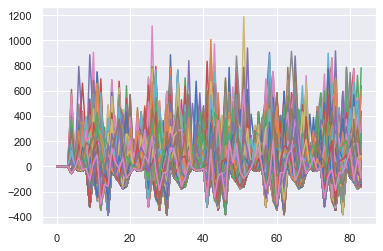

In [126]:
print(np.mean(nd_flat))
plt.plot(nd_flat);

 Find the linear decoder matrix

In [109]:
d_mtx = k_flat@np.linalg.pinv(nd_flat)
d_mtx.shape

(25, 84)

In [110]:
np.linalg.pinv(nd_flat).shape

(2047, 84)

Plot $r^2$ of the actual cursor data vs estimated from kinematic data

In [111]:
def plot_r2(xdata, ydata):
    plt.scatter(xdata, ydata)
    slope, intercept, r, p, se = scipy.stats.linregress(np.ndarray.flatten(xdata), np.ndarray.flatten(ydata))
    
    plt.plot(np.linspace(min(np.sort(np.ndarray.flatten(xdata))),max(np.sort(np.ndarray.flatten(xdata))),10),np.linspace(min(np.sort(np.ndarray.flatten(xdata))),max(np.sort(np.ndarray.flatten(xdata))),10)*slope+ intercept,'r')
#     plt.xlabel("cursor " + str(label))
#     plt.ylabel("prediction: cursor " + str(label))
    plt.title("r-squared = " + str(r))
    plt.show()

In [114]:
kin_calc = np.zeros((k_flat.shape[0] , len(tr)))
for iT_idx, iT_val in enumerate(tr):
    kin_calc[:, iT_idx] = d_mtx@nd_flat[:, iT_idx]
k_vals = np.delete(k_flat, slice(None, None, 5))
k_vals.shape

(40940,)

In [122]:
k_flat

array([[-0.50696394, -0.18363578, -0.33711977, ..., -0.22196202,
        -0.35512426, -0.57400362],
       [ 0.64126881, -1.03694282, -0.03970849, ..., -0.05496295,
        -0.23770445, -0.20341549],
       [ 0.33965621, -2.87668067, -1.51722208, ...,  0.15212935,
        -1.89574606, -1.04195454],
       ...,
       [ 1.31038631,  5.27277505,  2.7658679 , ...,  0.7158933 ,
         0.40957866,  3.77447777],
       [ 1.26195605,  4.39203813,  2.51186443, ...,  3.64518828,
        -3.86229197, -3.50846028],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [121]:
k_vals = np.delete(k_flat, np.arange(4, k_flat.size, 5))

array([-0.50696394, -0.18363578, -0.33711977, ...,  1.        ,
        1.        ,  1.        ])

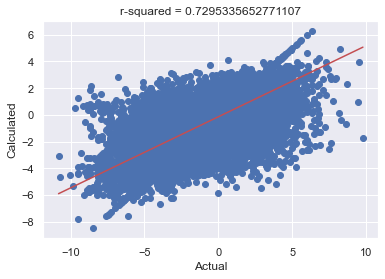

In [113]:

plt.xlabel("Actual")
plt.ylabel("Calculated")
plot_r2(k_flat.flatten(),kin_calc.flatten())

In [91]:
d_mtx.shape

(25, 84)

Text(0.5, 1.0, 'decoder matrix')

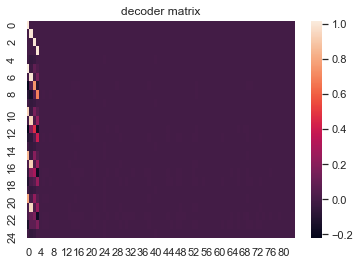

In [92]:
seaborn.heatmap(d_mtx)
plt.title("decoder matrix")

In [93]:
d_mtx

array([[ 1.00000000e+00, -4.62837234e-14,  2.65659890e-14, ...,
        -9.25383495e-18, -2.86009145e-17, -2.28800540e-17],
       [-3.35668993e-15,  1.00000000e+00,  4.89083600e-16, ...,
         7.10067720e-18, -2.46750862e-16,  1.04293473e-16],
       [ 2.29712083e-14,  2.10942375e-14,  1.00000000e+00, ...,
         1.72496566e-16,  1.58293517e-17,  1.02999206e-17],
       ...,
       [ 1.64863288e-02,  9.94208285e-02,  1.66810441e-01, ...,
         3.29246995e-04,  2.62396727e-04,  9.21820773e-04],
       [-1.36720344e-01,  7.31983672e-02,  7.00171154e-02, ...,
        -1.33785311e-03, -6.81461441e-05,  5.84841533e-04],
       [-1.53235525e-02, -5.19662517e-02, -3.74375553e-02, ...,
         7.42972242e-05, -3.83790518e-05, -2.24988631e-04]])